# SUSI sweRun
This script runs Susi* for one or more than one sites in Sweden.
It tryes to facilitate a form to get the parameters, collects the smhi weather data and storage the outputs in a centralized folder per site.

Follow the link to susi ....
get the general instructions from ...

Alejandro G.
 /// I have to improve the description ///

In [1]:
# Importing general libraries

import numpy as np
import pandas as pd
from datetime import datetime
import configparser
import argparse
import matplotlib.pylab as plt
import seaborn as sns
import sys
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.misc import derivative
from scipy.interpolate import InterpolatedUnivariateSpline as interS
from scipy.sparse import  diags
from scipy.sparse.linalg import  spsolve
#----------------------------------------------------------------------------
# Install non-standard packages
# !pip install xlsxwriter
# !pip install xlrd==1.2.0
# !pip install pyproj
# #--------------------------
# !pip install netCDF4
# !pip install datetime
# !pip install xlrd --upgrade
# !pip install dataframe_image
# # --------------------------
from pyproj import CRS, Transformer
import os

In [2]:
# Importing repositories 
if not os.path.exists('susi_2022'): 
    !git clone https://github.com/annamarilauren/susi_2022
else: print("Susi repository is already in yor computer")

if not os.path.exists('susi_SMHI'): 
    !git clone https://github.com/alejandrogandara/susi_SMHI
else: print("SMHI collect repository is already in yor computer")

Susi repository is already in yor computer
SMHI collect repository is already in yor computer


In [3]:
# Importing local libraries

import scripts.import_param as importParam # script to import from xls to dict
import susi_SMHI.susi_SMHI as smhi

newpathsusi = 'susi_2022'
if newpathsusi not in sys.path: sys.path.insert(0,newpathsusi)
newpathsusi = 'susi_SMHI/'
if newpathsusi not in sys.path: sys.path.insert(0,newpathsusi)
# -----------------------------------------------------------------------------
from susi.susi_utils import read_FMI_weather
from susi.susi_main import Susi
from inputs.susi_para import get_susi_para
from susi.susi_io import *

print (f"SUSI is ready to run!")

SUSI is ready to run!


### Local functions

In [4]:
# gets parameters from  file
# This script provides functionality to get data from an xmlx file. You will find a template at ./inputs/param_template.xlsx
# pFile: parameter file

from pandas import read_excel
import traceback
from datetime import datetime

def getParamFile(path):
    try: pFile = read_excel(path)
    except: 
        print('file does not exists')
        return
    return pFile

def getVariablesFromFile(pFile, site):
    # var [True, False]
    # file ['file path']
    vars = {}
    pFile=pFile[(pFile['commented'] != '#') & (pFile['path'].isna())]
    pFile.reset_index()
    for ind in pFile.index:
        if pFile['type'][ind] == 'date': 
            
            date = datetime.strptime(pFile[site][ind], '%Y-%m-%d %H:%M:%S')
            globals()[pFile['var'][ind]] = date
            vars[pFile['var'][ind]] = date
            #datetime.datetime(date.year,date.month,date.day)
        else: 
            globals()[pFile['var'][ind]] = pFile[site][ind] 
            vars[pFile['var'][ind]] = pFile[site][ind]
        print('variable updated: ' + pFile['var'][ind]+' = '+ str(pFile[site][ind]))
    return vars

# gets parameters from param file and fill dictionaries in memory
def getDicInFile(pFile, site):
    pFile=pFile[(pFile['commented'] != '#') & (pFile['path'].notnull())]
    pFile.reset_index()

    for uvar in pFile['var'].unique():
        sp = pFile[pFile['var'] == uvar]
        print('------------------------------')
        print('dictionary: '+ uvar + '  keys:' + str(len(sp)))
        globals()[uvar]
        for ind in sp.index:
            try: 
                path = pFile['path'][ind].replace(', ','][')
                if pFile['type'][ind] == 'str': 
                    value = "'"+ str(pFile[site][ind]) + "'"
                else: value = str(pFile[site][ind])
                #exec(pFile['var'][ind] + pFile['path'][ind].replace(',','][').replace(' ', '') + ' = ' + str(pFile[site][ind]))
                line = uvar + path + ' = ' + value
                print(line)
                exec(line)
            #except: print('ERROR: '+ uvar + path + ' = ' + value + ' NOT UPDATED' )
            except Exception: traceback.print_exc()

### Reading the parameter file, setting up the folders; motti and weather files.

In [5]:
# Name convention
# weather file:     inputs/.../weather/  {site}_weather.csv
# motti file:       inputs/.../motti/    {site}_motti_lyr_0.xlsx
# You will define the input folder later

folderName= importParam.mkfolder('outputs/')               # output folder
graph_folder = importParam.mkfolder(f'{folderName}/graphs/')

weatherPath = 'inputs/sweden/weather/'                          # Where the weather file is
mottipath = 'inputs/sweden/motti/'                         # folder where motti files are


paramFile = getParamFile("inputs\sweden\parameters.xlsx")  # map the param file

sitesNames = paramFile.columns[9:]  # extract the site names from param file header
print(pd.DataFrame(sitesNames))

# Defines motti files, please follow the name convention or add it manually
data_files = {}
for key in sitesNames:
    data_files[key] = {}
    data_files[key]['para'] = f'susi_para_{key}'
    data_files[key]['weatherFile'] = f'{key}_weather.csv'
    data_files[key]['motti_lyr_0'] = f'{key}_motti_input_lyr_0.xlsx'
    data_files[key]['motti_lyr_1'] = f'{key}_motti_input_lyr_0.xlsx'        # fake, just to fill the gap
    data_files[key]['motti_lyr_2'] = f'{key}_motti_input_lyr_0.xlsx'        # fake, just to fill the gap

outputs/ already exists, ready to go
outputs//graphs/ already exists, ready to go
               0
0      01_Bjdamm
1      03_Korpis
2    04_Fröjered
3     05_SträRed
4      06_Risabo
5     07_Rothult
6     08_Ydreham
7     09_Gröngöl
8   10_Hällehult
9      11_Ökalix
10     12_Ökalix
11     13_Ökalix
12    14_Höglund
13   15_Jörnmark


### Which site are you running?

In [6]:
siteID = 13
site = list(data_files.keys())[siteID]
site

'15_Jörnmark'

### 3.1 Default inputs

In [7]:
mottifile = {'path':mottipath,
              'dominant':{1: data_files[site]['motti_lyr_0']},
              'subdominant':{0:data_files[site]['motti_lyr_1']},
              'under':{0:data_files[site]['motti_lyr_2']}}

weatherData = data_files[site]['weatherFile']
sarkaSim = paramFile.loc[paramFile.path == "['start_date']"][site].values[0]
start_date = paramFile.loc[paramFile.path == "['start_date']"][site].values[0]
end_date = paramFile.loc[paramFile.path == "['end_date']"][site].values[0]
start_yr = start_date.year 
end_yr = end_date.year
yrs = (end_date - start_date).days/365.25

sarkaSim = 40.                                                                  # strip width, ie distance between ditches, m
n = int(sarkaSim / 2)                                                           # number of computation nodes in the strip


#age = paramFile.loc[paramFile.path == "['age']"][site].values[0]
dominant_age = float(paramFile.loc[paramFile['var'] == "age_dominant"][site].values[0])
#dominant_age = 85.

ageSim = {'dominant': dominant_age * np.ones(n),
          'subdominant': 0*np.ones(n),
          'under': 0*np.ones(n)}                                                         # age of the stand in each node

sfc =  np.ones(n, dtype=int)*3                                                            # site fertility class


#ageSim['dominant'][int(n/2):] = 2.
#ageSim[4:-4] = 2.

          
wpara, cpara, org_para, spara, outpara, photopara = get_susi_para(wlocation='undefined', peat='krycklan', 
                                                                          folderName=folderName, hdomSim=None,  
                                                                          ageSim=ageSim, sarkaSim=sarkaSim, sfc=sfc, susiPath = weatherPath,
                                                                          n=n)

#spara['canopylayers']['dominant'][int(n/2):] = 2                                                                        
#spara['canopylayers']['subdominant'][:int(n/2)] = 1                                                                        


In [8]:
# import parameter from './inputs/sweden/parameters.xlsx' book 
getDicInFile(paramFile, site)
#spara['age'] = ageSim

------------------------------
dictionary: wpara  keys:9
wpara['start_date'] = '2008-01-01 00:00:00'
wpara['end_date'] = '2016-12-31 00:00:00'
wpara['infolder'] = '/sweden/'
wpara['infile_d'] = '15-Jörnmark_weather.csv'
wpara['start_yr'] = 2008
wpara['end_yr'] = 2016
wpara['description'] = 'Sweden, 15-Jörnmark'
wpara['lat'] = 65.16666666666667
wpara['lon'] = 20.25
------------------------------
dictionary: spara  keys:16
spara['sitename'] = '15-Jörnmark'
spara['species'] = 'Spruce'
spara['hdom'] = 18
spara['vol'] = 178
spara['smc'] = 'Peatland'
spara['nLyrs'] = 30
spara['dzLyr'] = 0.05
spara['ditch depth west'] = [-0.6]
spara['ditch depth east'] = [-0.6]
spara['ditch depth 20y west'] = [-0.6]
spara['ditch depth 20y east'] = [-0.6]
spara['scenario name'] = ['Control', 'TEST']
spara['slope'] = 2.447998
spara['peat type'] = ['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S']
spara['peat type bottom'] = ['S']
spara['vonP'] = True
------------------------------
dictionary: outpara  keys:1
outpara['net

### Getting weather data

In [9]:
spara['age']['dominant']

array([85., 85., 85., 85., 85., 85., 85., 85., 85., 85., 85., 85., 85.,
       85., 85., 85., 85., 85., 85., 85.])

In [10]:
workingFolder = os.getcwd()
wfile = smhi.getWeather(site, wpara['lon'], wpara['lat'], start_date, end_date, weatherPath, workingFolder, stations_nearby= 10)

     varType  percent_missing
 OmaTunniste            100.0
       OmaIt            100.0
OmaPohjoinen            100.0
       Kunta              0.0
      siteid              0.0
        aika              0.0
       vuosi              0.0
          kk              0.0
       paiva              0.0
   longitude              0.0
    latitude              0.0
      t_mean              0.0
       t_max              0.0
       t_min              0.0
    rainfall              0.0
   radiation              0.0
         hpa              0.0

The weather file 15_Jörnmark from 20080101 to 20161231 is ready to go


In [11]:
workingFolder

'\\\\nas1.seksko.slu.se\\Extension_100TB\\agandara\\projects\\forestProductivity\\git\\susi-swe'

In [12]:
forc=read_FMI_weather(0, start_date, end_date, sourcefile=wfile)  

         # read weather input

 + Reading meteorological input file from 
    - inputs/sweden/weather/15_Jörnmark_weather.csv


### Importing parameters from table

In [13]:
# Print some of this
spara['ditch depth west'] 
outpara['netcdf']
spara
weatherData

'15_Jörnmark_weather.csv'

### Checking the weather data
The data is collected from SMHI using the dates and coordinates from the param file, but is possible to use the susi_SMHI module manually.


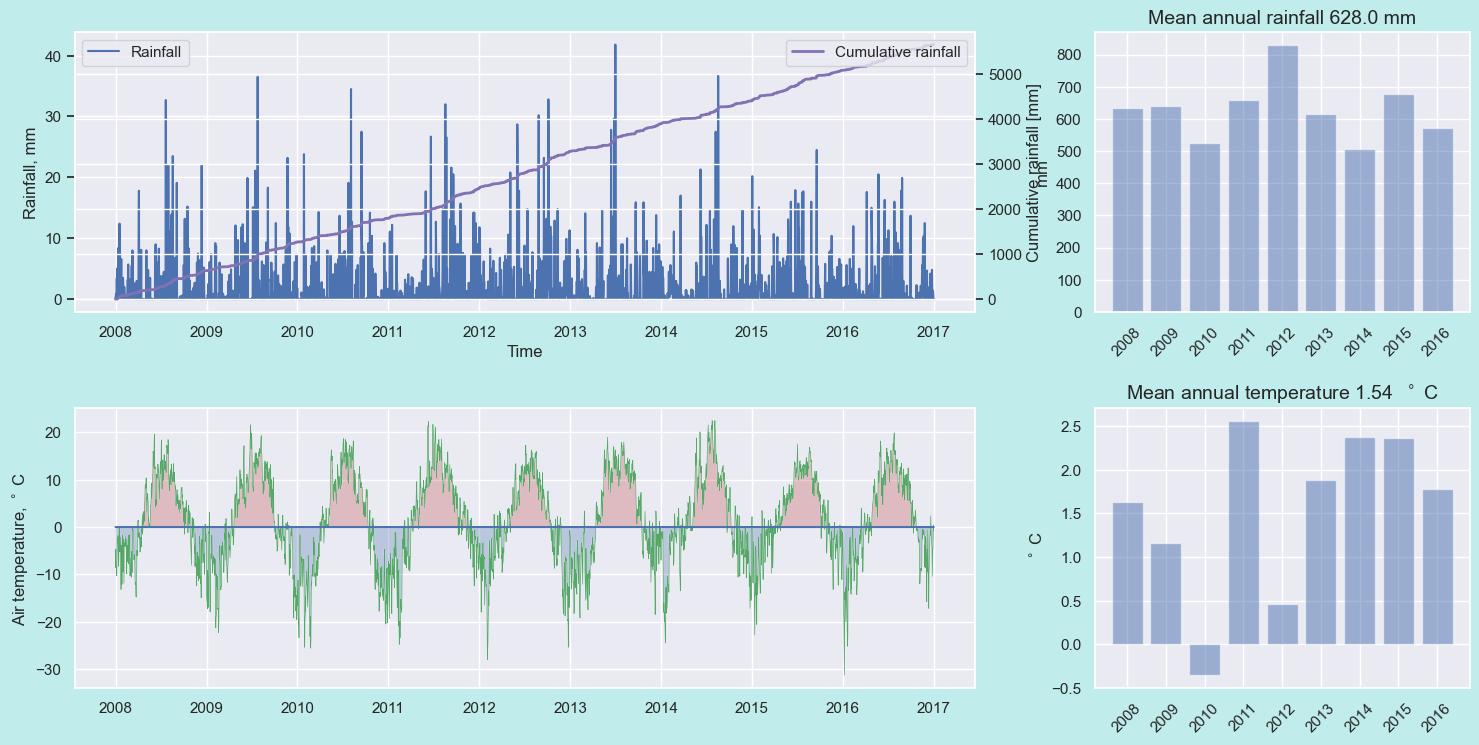

In [14]:
from susi.susi_io import *
graph_output = graph_folder + weatherData[:-4] + '_graph.png'
weather_fig(forc)        #Draw the weather input figure

### 3.4 Run the simulation

In [15]:
# in case Susi() returns write permission error
#ncf.close()

In [16]:
susi = Susi()
susi.run_susi(forc, wpara, cpara, org_para, spara, outpara, photopara, start_yr, end_yr, wlocation = 'undefined', 
                                mottifile=mottifile, peat= 'krycklan', photosite='All data', 
                                folderName=folderName,ageSim=ageSim, sarkaSim=sarkaSim, sfc=sfc)

******** Susi-peatland simulator v.10 (2022) c Annamari Laurén *********************
           
Initializing stand and site:
**** creating Susi netCDF4 file: outputs/15_Jornmark_susi.nc ****
    + netCDF file created
      - Weather input: Sweden, 15-Jörnmark , start: 2008 , end: 2016
      - Latitude: 65.16666666666667 , Longitude: 20.25
dominant initialized
subdominant initialized
under initialized
  + Site:
   + Number of columns: 20
    - Site fertility class:
     [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
  + Stand:
    - age:
        dominant: [85. 85. 85. 85. 85. 85. 85. 85. 85. 85. 85. 85. 85. 85. 85. 85. 85. 85.
 85. 85.] yrs
        subdominat: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] yrs
        under: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] yrs
  + Soil: 
    - peat top: S , von P: 2
    - peat bottom: S , von P: 5
  + Drainage:
    - Strip widht: 40.0 m
    - Ditch depth west: [-0.6]
    - Ditch depth east: [-0.6]
    - Scenarios

d:\Users\aoga0001\Anaconda3\envs\susiPy\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
d:\Users\aoga0001\Anaconda3\envs\susiPy\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Canopy and moss layer hydrology initialized
Peat strip initialized
30 0.05
Peat temperature profile initialized
Soil hydrology, temperature and DOC models initialized
***********************************
Computing canopy and soil hydrology  3288  days scenario: Control
Resetting strip scenario
  - day # 0  hdom  21.32  m,  LAI  10.04  m2 m-2
  - day # 0 iterations 9
  - day # 365  hdom  21.32  m,  LAI  10.04  m2 m-2
  - day # 365 iterations 6


\\nas1.seksko.slu.se\Extension_100TB\agandara\projects\forestProductivity\git\susi-swe\susi_2022\susi\canopylayer.py:226: RuntimeWarning: invalid value encountered in divide
  self.NPP = self.NPP * nut_stat / self.stems  * 1.1                     # returned back to tree basis unit
\\nas1.seksko.slu.se\Extension_100TB\agandara\projects\forestProductivity\git\susi-swe\susi_2022\susi\canopylayer.py:227: RuntimeWarning: invalid value encountered in divide
  self.NPP_pot = self.NPP_pot * nut_stat / self.stems * 1.1               # returned back to tree basis units


  - day # 730  hdom  21.83  m,  LAI  10.13  m2 m-2
  - day # 730 iterations 6
  - day # 1095  hdom  21.91  m,  LAI  10.22  m2 m-2
  - day # 1095 iterations 6
  - day # 1460  hdom  21.94  m,  LAI  10.25  m2 m-2
  - day # 1460 iterations 4
  - day # 1825  hdom  21.96  m,  LAI  10.27  m2 m-2
  - day # 1825 iterations 4
  - day # 2190  hdom  21.96  m,  LAI  10.27  m2 m-2
  - day # 2190 iterations 7
  - day # 2555  hdom  21.96  m,  LAI  10.27  m2 m-2
  - day # 2555 iterations 6
  - day # 2920  hdom  21.96  m,  LAI  10.27  m2 m-2
  - day # 2920 iterations 6
  - day # 3285  hdom  21.96  m,  LAI  10.27  m2 m-2
  - day # 3285 iterations 6


In [17]:
spara['age']['dominant']

array([85., 85., 85., 85., 85., 85., 85., 85., 85., 85., 85., 85., 85.,
       85., 85., 85., 85., 85., 85., 85.])

## Draw figures

C:\Users\aoga0001\AppData\Roaming\Python\Python39\site-packages\numpy\ma\core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


IndexError: index exceeds dimension bounds

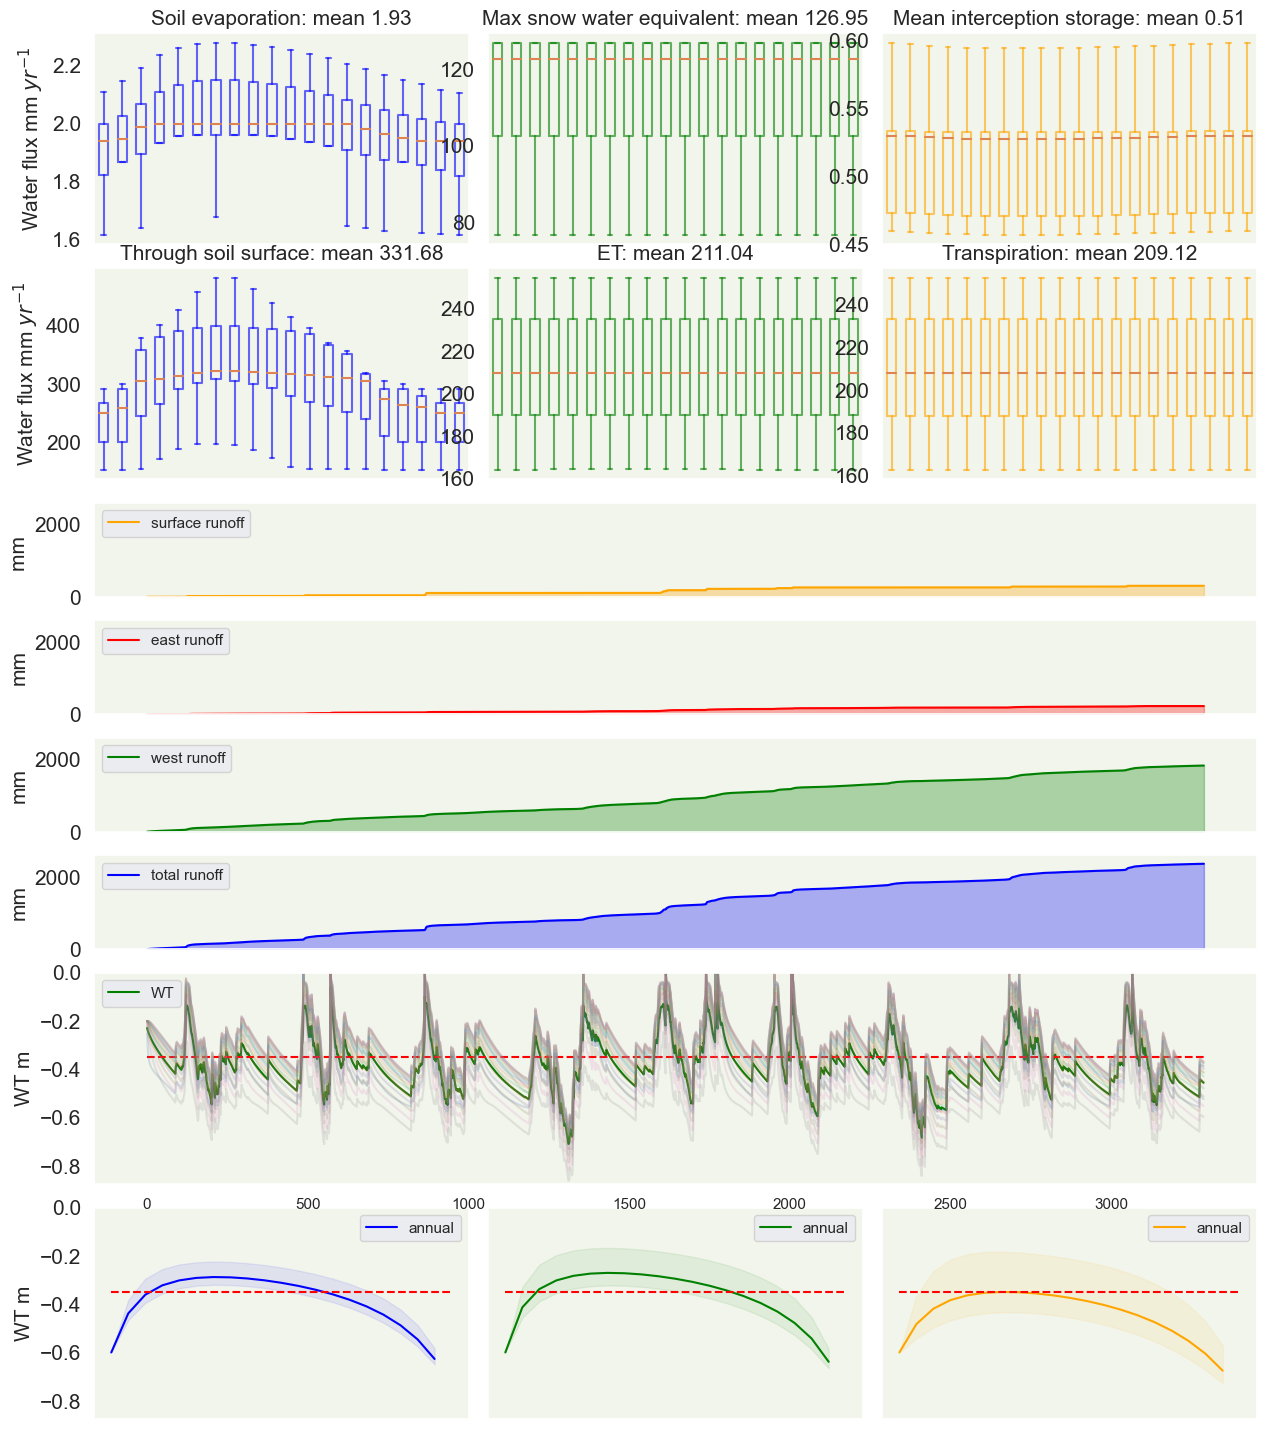

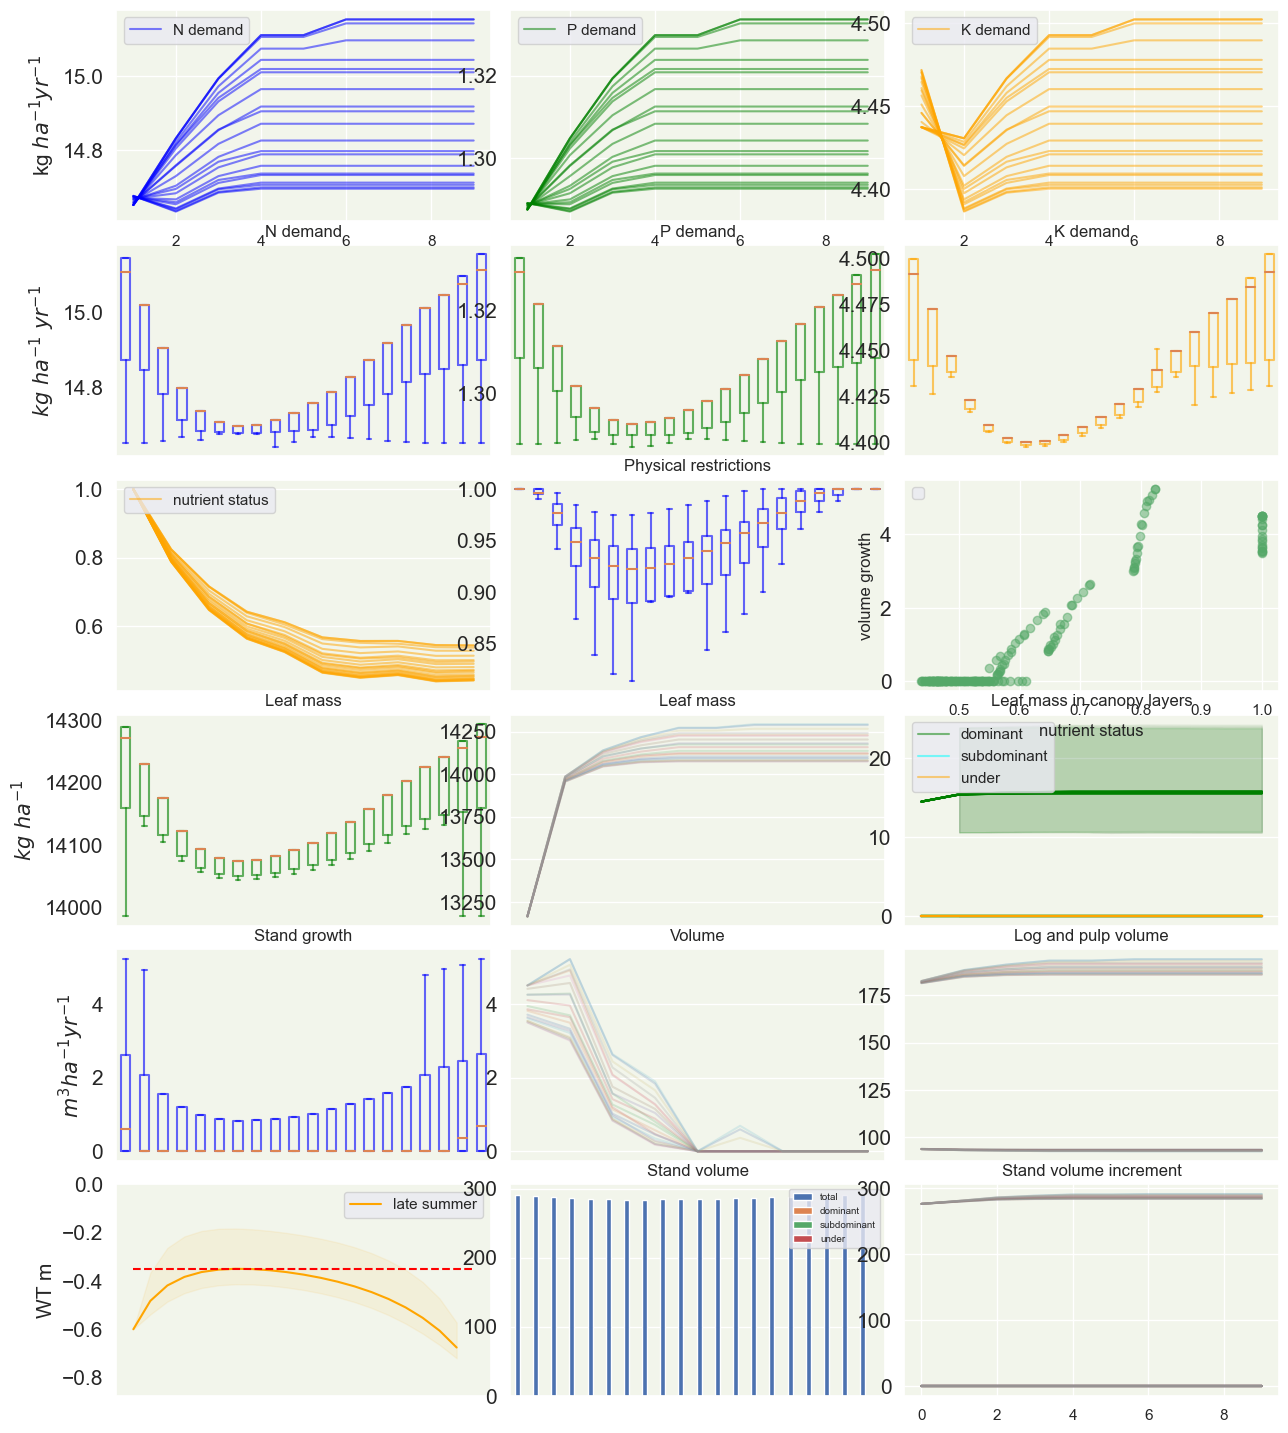

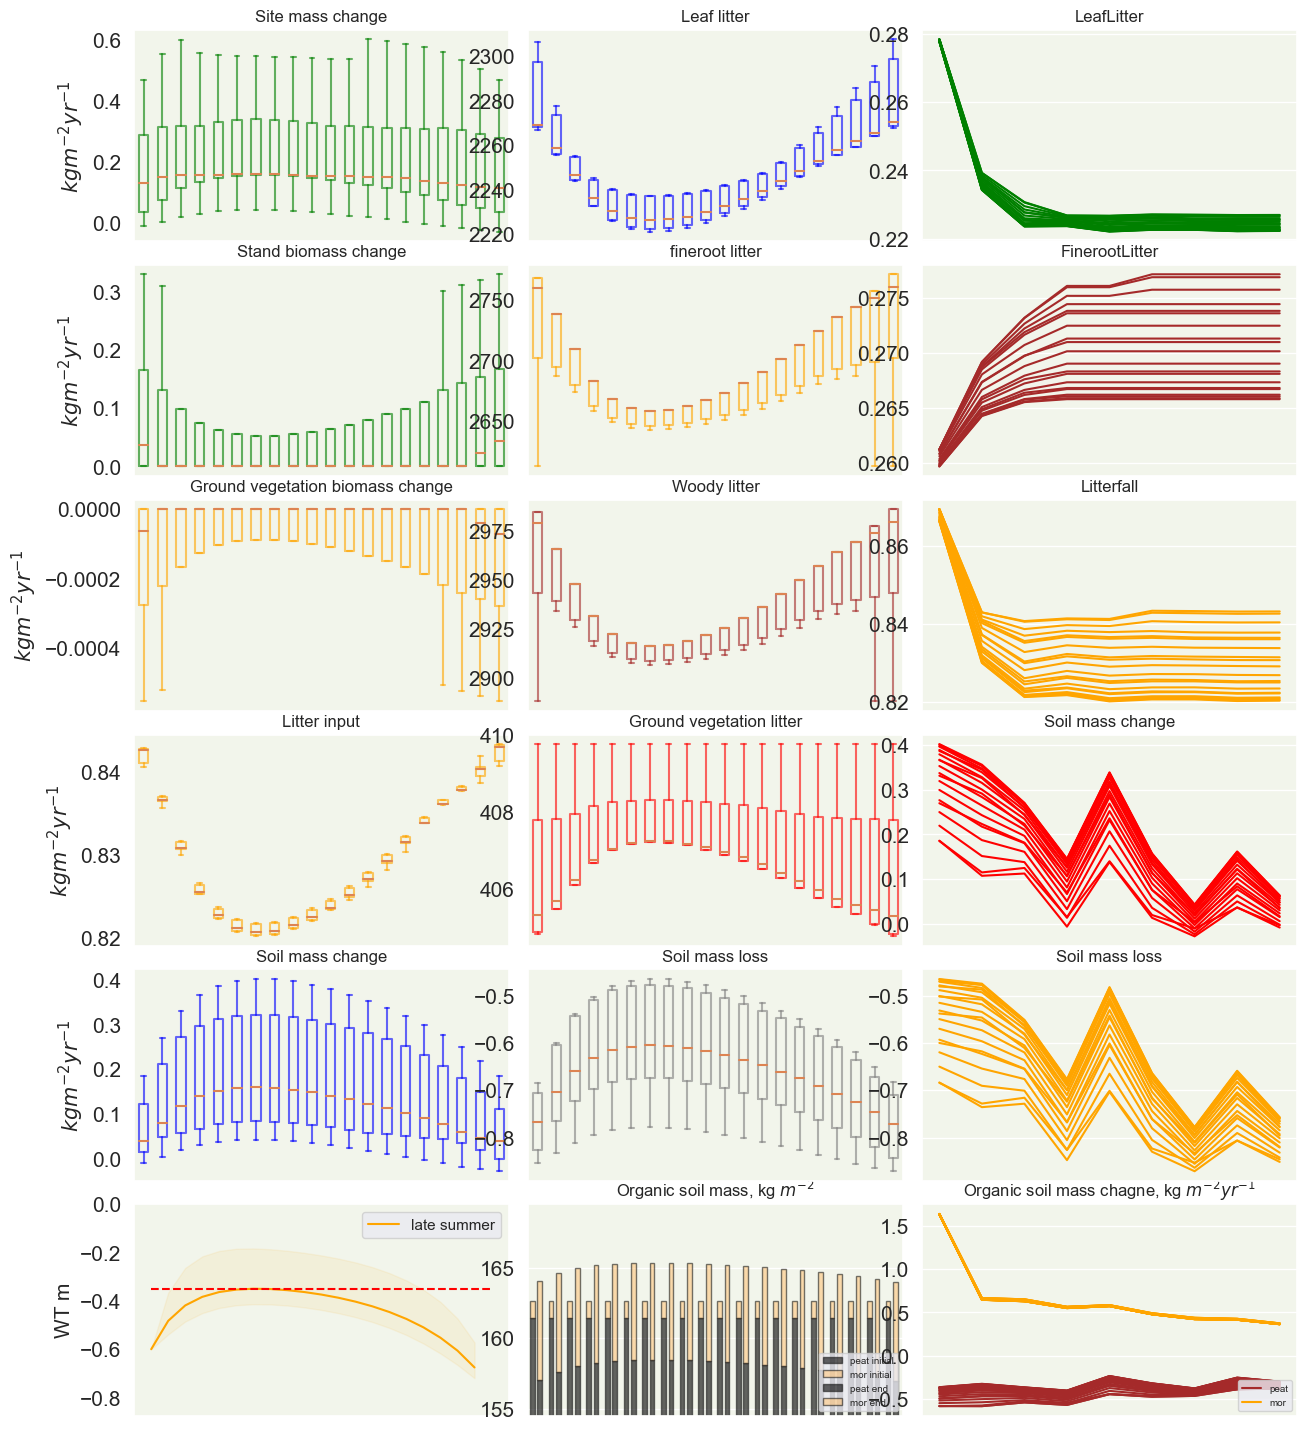

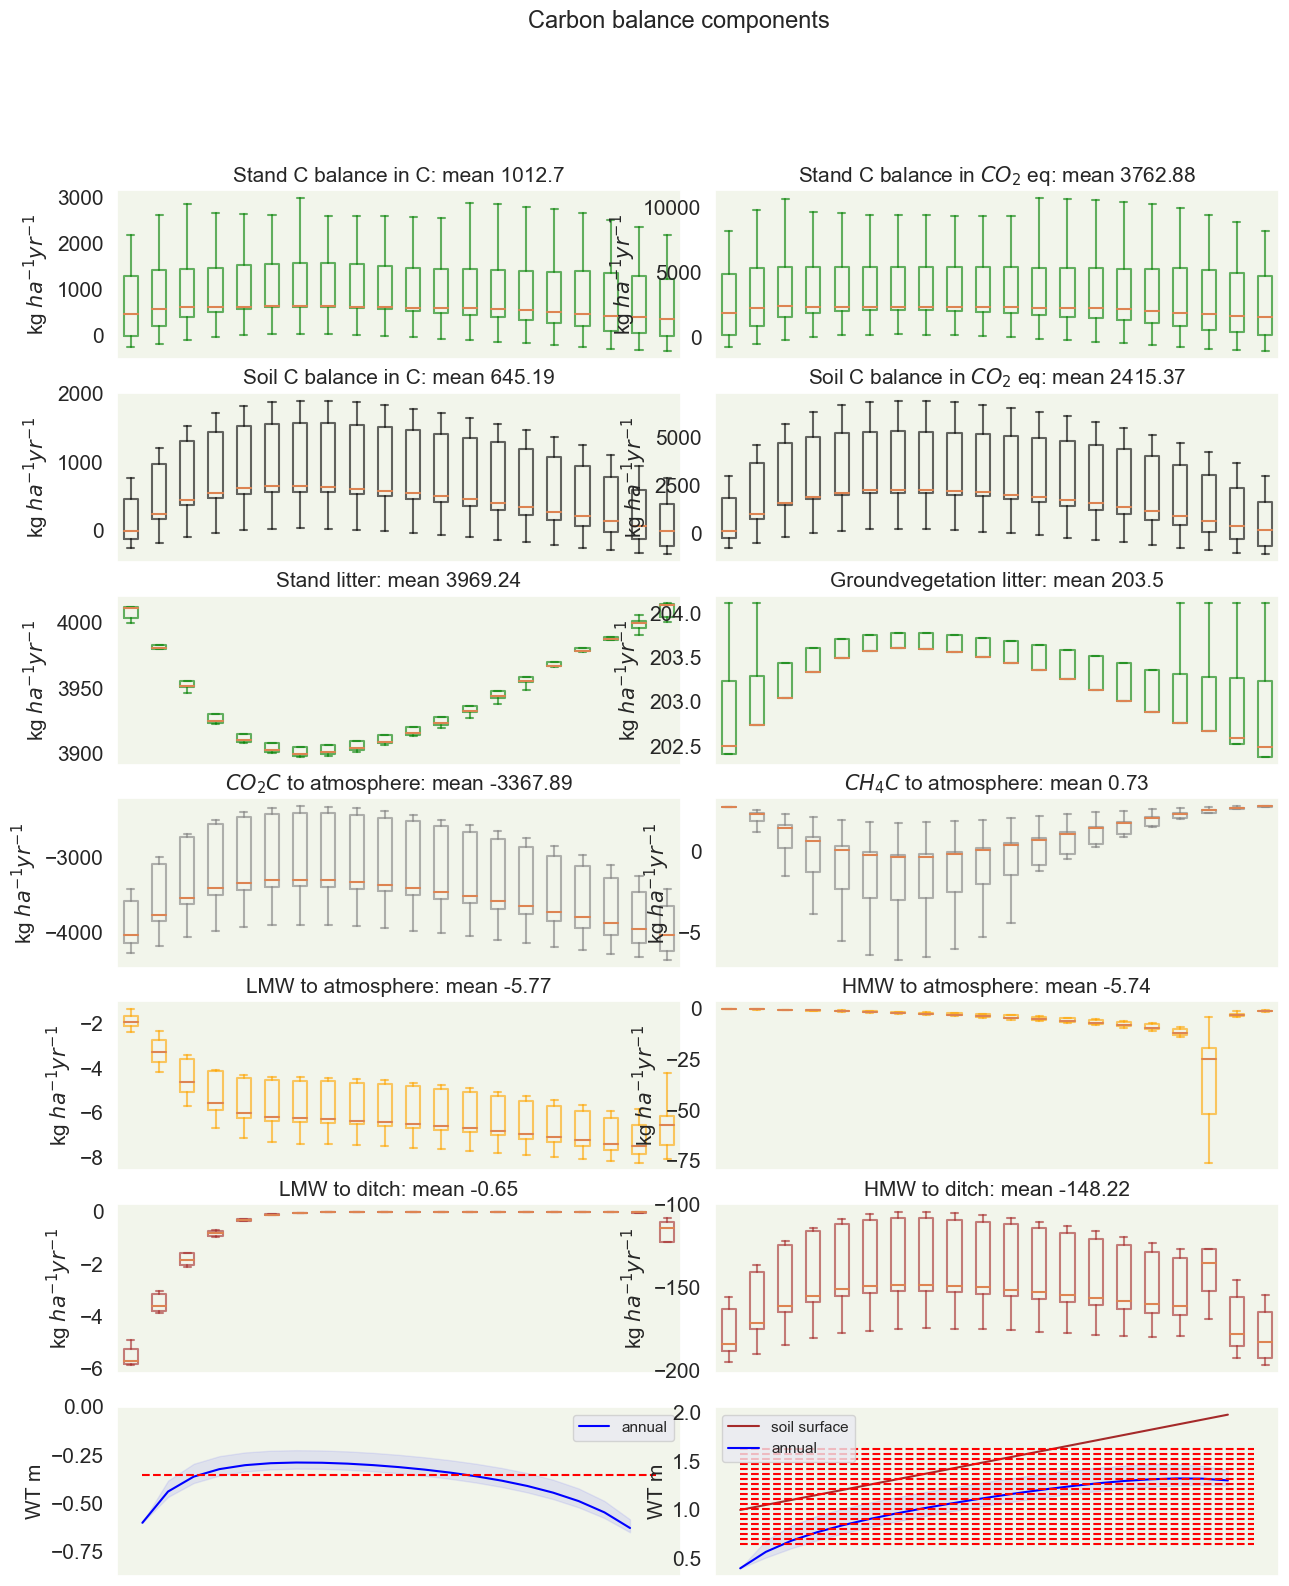

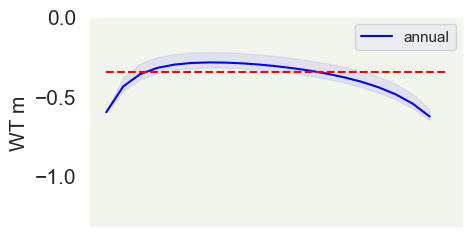

In [18]:
from susi.figures import *
from netCDF4 import Dataset 

#ff = r'susi_2022/outputs/susi.nc'
ff=outpara['outfolder']+ outpara['netcdf']  # AG added
#ff=r'outputs/swe_site_05_StraRed_susi.nc'
scen = 0

hydrology(ff, scen)
stand(ff, scen)
mass(ff, scen)
carbon(ff, scen)
compare_1(ff, [0,1])


In [ ]:
compare_scens(ff)

In [ ]:
# v_ini, v, iv5,  cbt, dcbt, cb, dcb, w,dw,logs,pulp, dv,dlogs,dpulp,yrs, bmgr,  \
#                                     Nleach, Pleach, Kleach, DOCleach, runoff, nrelease, \
#                                     prelease, krelease, ch4release = run_susi(forc, wpara, cpara, 
#                                     org_para, spara, outpara, photopara, start_yr, end_yr, wlocation = 'undefined', 
#                                     mottifile=mottifile, peat= 'other', photosite='All data', 
#                                     folderName=folderName,ageSim=ageSim, sarkaSim=sarkaSim, sfc=sfc, susiPath=susiPath) 